Importación de datos

In [1]:
import kagglehub
import shutil
import os


# Descargar dataset
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

# Obtener el directorio de trabajo actual
destination_path = os.getcwd()+'/dataset/'
if not os.path.exists(destination_path):
    # Copia la carpeta de forma recursiva
    shutil.copytree(path, destination_path)

Cargar imágenes y etiquetas

In [2]:
import json

# Abre el archivo JSON
with open("setup.json") as archivo:
    setup = json.load(archivo)

In [3]:
import cv2
import os
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from tqdm import tqdm

# Función para procesar y extraer características en lugar de almacenar imágenes completas
def process_file(file_path, label, resize=True, X_resolution_size= setup['X_resolution_size'], Y_resolution_size= setup['Y_resolution_size'], color_mode="IMREAD_GRAYSCALE"):
    """
    Procesa un archivo de imagen, lo redimensiona y extrae características.
    :param file_path: Ruta del archivo de imagen.
    :param label: Etiqueta de la clase.
    :param resize: Si se debe redimensionar la imagen.
    :param resizeResol: Resolución a la que redimensionar la imagen.
    :param color_mode: Modo de color para cargar la imagen (opciones: cv2.IMREAD_COLOR [RGB], IMREAD_GRAYSCALE [Grayscale]).
    :return: Un diccionario con características y etiqueta.
    """

    try:
        color = cv2.IMREAD_GRAYSCALE  if color_mode == "IMREAD_GRAYSCALE" else cv2.IMREAD_COLOR
        image = cv2.imread(file_path, color)  # Load in GRAY mode
        if resize:
            image = cv2.resize(image, (X_resolution_size, Y_resolution_size))  # Resize to X_resolution_size x Y_resolution_size
        if image is not None:
            return {'features': image.flatten(), 'label': label}  # Store features
        else:
            print(f"Error loading image: {file_path}")
    except Exception as e:
        print(f"Exception processing {file_path}: {e}")
    return None

# Generador para manejar archivos sin retener imágenes completas en memoria
def image_loader(dirs, labels, max_workers=4):
    for dir, label in zip(dirs, labels):
        if not os.path.exists(dir):
            print(f"Directorio no encontrado: {dir}")
            continue

        files = [os.path.join(dir, file) for file in os.listdir(dir)]
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            print(setup['X_resolution_size'])
            results = list(tqdm(executor.map(lambda f: process_file(f, label, True, setup['X_resolution_size'], setup['Y_resolution_size'] ), files), 
                                desc=f"Procesando {dir}", total=len(files)))
        for result in results:
            if result is not None:
                yield result

# Carpeta del dataset
dataset_path = 'dataset/lung_colon_image_set/'

# Definir las subcarpetas de las clases 
dirs = [
    os.path.join(dataset_path, 'lung_image_sets/lung_n'),
    os.path.join(dataset_path, 'colon_image_sets/colon_aca'),
    os.path.join(dataset_path, 'colon_image_sets/colon_n'),
    os.path.join(dataset_path, 'lung_image_sets/lung_aca'),
    os.path.join(dataset_path, 'lung_image_sets/lung_scc')
]

labels = [0, 1, 2, 3, 4]

# Usar el generador optimizado
data = []
for result in image_loader(dirs, labels):
    data.append(result)

# Convertir a un DataFrame más ligero
df = pd.DataFrame(data)

512


Procesando dataset/lung_colon_image_set/lung_image_sets/lung_n: 100%|██████████| 5000/5000 [00:02<00:00, 1702.48it/s]


512


Procesando dataset/lung_colon_image_set/colon_image_sets/colon_aca: 100%|██████████| 5000/5000 [00:04<00:00, 1163.89it/s]


512


Procesando dataset/lung_colon_image_set/colon_image_sets/colon_n: 100%|██████████| 5000/5000 [00:06<00:00, 811.14it/s]


512


Procesando dataset/lung_colon_image_set/lung_image_sets/lung_aca: 100%|██████████| 5000/5000 [00:08<00:00, 589.90it/s]


512


Procesando dataset/lung_colon_image_set/lung_image_sets/lung_scc: 100%|██████████| 5000/5000 [00:11<00:00, 422.65it/s]


Separación de los datos

In [4]:
import torch
from sklearn.model_selection import train_test_split

# Split the DataFrame into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.5, random_state=42, stratify=train_df['label'])

Preparación de los datos

In [9]:
num_classes = len(df['label'].unique())
print(num_classes)

5


In [ ]:
# Convert the labels to tensors
train_labels = torch.tensor(train_df['label'].tolist())
val_labels = torch.tensor(val_df['label'].tolist())
test_labels = torch.tensor(test_df['label'].tolist())

In [ ]:
print(torch.nn.functional.one_hot(torch.tensor(train_df['label'].values), num_classes=num_classes).to_list().shape)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [15]:
import torch
import pandas as pd

# Convert the labels to one-hot
train_df['label'] = torch.nn.functional.one_hot(torch.tensor(train_df['label'].values), num_classes=num_classes)
val_df['label'] = torch.nn.functional.one_hot(torch.tensor(val_df['label'].values), num_classes=num_classes)
test_df['label'] = torch.nn.functional.one_hot(torch.tensor(test_df['label'].values), num_classes=num_classes)

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

Visualizar las imágenes

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

def visualize_example(row:int, dataframe:pd.core.frame.DataFrame, X_Resolution_size = setup['X_resolution_size'], Y_Resolution_size = setup['Y_resolution_size'], color_mode = getattr(cv2, setup['color_mode'])):
    """
    Visualiza un ejemplo de imagen a partir de las características extraídas en un DataFrame.
    :param row: Fila del DataFrame que contiene las características de la imagen.
    :param X_Resolution_size: Tamaño de resolución en X.
    :param Y_Resolution_size: Tamaño de resolución en Y.
    :param color_mode: Modo de color para visualizar (opciones: cv2.IMREAD_COLOR [RGB], IMREAD_GRAYSCALE [Grayscale]).
    """

    features = dataframe.iloc[row]['features']
    if color_mode == cv2.IMREAD_COLOR:
        # Reshape the flattened image back to its original dimensions (e.g., 512x512x3 for RGB)
        image = np.array(features).reshape(X_Resolution_size, Y_Resolution_size, 3)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct visualization
    elif color_mode == cv2.IMREAD_GRAYSCALE:
        # Reshape the flattened image back to its original dimensions (e.g., 512x512 for Grayscale)
        image = np.array(features).reshape(X_Resolution_size, Y_Resolution_size)
        plt.imshow(image, cmap='gray')  # Use grayscale colormap
    else:
        raise ValueError("Unsupported color mode. Use cv2.IMREAD_COLOR or cv2.IMREAD_GRAYSCALE.")
    
    plt.grid(False)
    plt.show()
    print("Label:", dataframe.iloc[row]['label'])



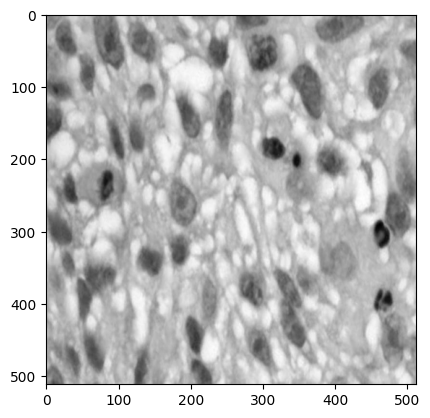

Label: 0


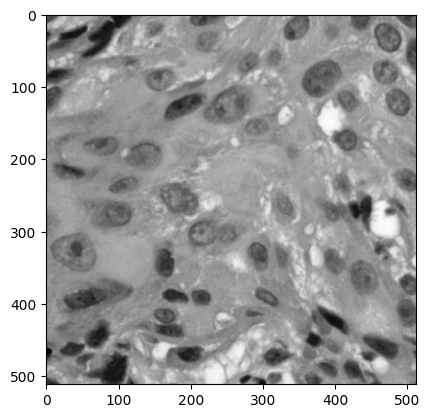

Label: 0


In [7]:
# Visualize the first 5 examples in X_test
for i, label in enumerate(test_df['label'][:2]):
    visualize_example(i, test_df)

In [8]:
num_classes = len(labels)
# Adjust input shape based on color mode
color_mode = "RGB"  # Change to "Grayscale" for grayscale images
if color_mode == "RGB":
    input_shape = (setup['X_resolution_size'], setup['Y_resolution_size'], 3)  # RGB images
else:
    input_shape = (setup['X_resolution_size'], setup['Y_resolution_size'], 1)  # Grayscale images

## Modelo de Javi

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definir el modelo secuencial con PyTorch
class CNNModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[2], out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * input_shape[0] * input_shape[1] // 64, 256)  # Ajustar según el tamaño de entrada
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = self.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = self.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)

# Crear el modelo
model = CNNModel(input_shape=(setup['X_resolution_size'], setup['Y_resolution_size'], 3), num_classes=num_classes)

# Mostrar el resumen del modelo
print(model)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Ejemplo de compilación del modelo
print("Modelo compilado con Adam y CrossEntropyLoss.")

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=524288, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
Modelo compilado con Adam y CrossEntropyLoss.


In [10]:
train_features = torch.tensor(np.array(train_df['features'][:piece].tolist()), dtype=torch.float32)
train_labels = torch.tensor(np.array(train_df['label'][:piece].tolist()), dtype=torch.long)
val_features = torch.tensor(np.array(val_df['features'][:piece].tolist()), dtype=torch.float32)
val_labels = torch.tensor(np.array(val_df['label'][:piece].tolist()), dtype=torch.long)


NameError: name 'piece' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import gc

# Función para calcular la precisión
def calcular_precision(outputs, labels):
    _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

# Definir el modelo
class Modelo(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Modelo, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

# Obtener dimensiones
input_dim = len(train_df['features'].tolist()[0])  # Dimensión de entrada
output_dim = len(set(train_df['label'].tolist()))  # Número de clases
model = Modelo(input_dim, output_dim)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **Liberar memoria antes de asignaciones grandes**
gc.collect()
torch.cuda.empty_cache()

# **Reducir el tamaño de los datos con `float16`**
train_dataset = TensorDataset(torch.tensor(np.array(train_df['features'].tolist()), dtype=torch.float16),
                              torch.tensor(np.array(train_df['label'].tolist()), dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(np.array(val_df['features'].tolist()), dtype=torch.float16),
                            torch.tensor(np.array(val_df['label'].tolist()), dtype=torch.long))

# **Crear DataLoaders para manejar datos en lotes pequeños**
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# **Entrenar el modelo**
epochs = 15

for epoch in range(epochs):
    model.train()
    
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # **Evaluación en el conjunto de validación**
    model.eval()
    with torch.no_grad():
        val_loss_total = 0
        correct = 0
        total = 0

        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model(X_val_batch)
            val_loss_total += criterion(val_outputs, y_val_batch).item()

            _, predicted = torch.max(val_outputs, 1)
            total += y_val_batch.size(0)
            correct += (predicted == y_val_batch).sum().item()

        accuracy = correct / total
        avg_val_loss = val_loss_total / len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy:.4f}")


RuntimeError: [enforce fail at alloc_cpu.cpp:115] data. DefaultCPUAllocator: not enough memory: you tried to allocate 15728640000 bytes.

## Modelo David

In [ ]:
# Cargamos un modelo pre-entrenado con Imagenet
vgg_model = VGG19(include_top=False, weights="imagenet", input_shape=input_shape)

# Congelamos al modelo / que los parámetros no se actualicen
for layer in vgg_model.layers[:12]:
  layer.trainable = False

In [ ]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(units=500, activation="relu"))
model.add(Dense(units=num_classes,   activation="softmax"))
model.compile(optimizer='sgd', # Mejor optimizador
              loss="categorical_crossentropy",
              metrics=["acc"])
history=model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2)

In [ ]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  epochs_range = np.arange(1, len(history.history['acc']) + 1)
  plt.plot(epochs_range,history.history['acc'])
  plt.plot(epochs_range,history.history['val_acc'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  epochs_range = np.arange(1, len(history.history['acc']) + 1)
  plt.plot(epochs_range,history.history['loss'])
  plt.plot(epochs_range,history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

In [ ]:
plot_acc(history)

In [ ]:
plot_loss(history)

## Modelo Erik

In [ ]:
# Crear un modelo simple de CNN para clasificación de imágenes
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Número de clases (6)
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Extraer métricas del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Número de épocas
epochs = range(1, len(train_loss) + 1)

# Crear las gráficas
plt.figure(figsize=(12, 5))

# Gráfica de pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Gráfica de exactitud (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
